<a href="https://colab.research.google.com/github/VedantDere0104/GANs/blob/main/Age_cGAN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Face Aging With Conditional Generative Adversarial Networks :- https://arxiv.org/abs/1702.01983

In [ ]:
####

In [ ]:
import torch
from torch import nn
import torchvision
from torchsummary import summary
from tqdm.auto import tqdm

In [ ]:
!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
!tar -xf wiki_crop.tar

--2021-02-05 14:59:49--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 811315200 (774M) [application/x-tar]
Saving to: ‘wiki_crop.tar.2’

wiki_crop.tar.2     100%[===================>] 773.73M  10.5MB/s    in 77s     

2021-02-05 15:01:07 (10.1 MB/s) - ‘wiki_crop.tar.2’ saved [811315200/811315200]



In [ ]:
import math
import os
import time
from datetime import datetime
from pathlib import Path
from glob import glob

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import torch.nn.functional as F

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):

    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
def calc_age(taken, dob):

    birth = datetime.fromordinal(max(int(dob) - 366, 1))

  
    if birth.month < 7:
        return taken - birth.year
    else:
        return taken - birth.year - 1

In [ ]:
def load_data(dataset='wiki', data_dir='./wiki_crop'):

    meta_path = Path(data_dir) / f'{dataset}.mat'
    meta = loadmat(meta_path)
    meta_data = meta[dataset][0, 0]

    full_path = meta_data['full_path'][0]
    full_path = [y for x in full_path for y in x]


    dob = meta_data['dob'][0]


    photo_taken = meta_data['photo_taken'][0]

    age = [calc_age(photo_taken[i], dob[i]) for i in range(len(dob))]

    clean_mapping = {pth:age for (pth, age) in zip(full_path, age) if age > 0}
    

    full_path = list(clean_mapping.keys())
    age = list(clean_mapping.values())

    return full_path, age

In [ ]:
def scale(x, feature_range=(-1, 1)):

    min, max = feature_range
    x = x * (max - min) + min
    return x

In [ ]:
bins = [18, 29, 39, 49, 59]
def one_hot(x, bins):

    x = x.numpy()
    idxs = np.digitize(x, bins, right=True)
    idxs = idxs.reshape(-1,1)
    z = torch.zeros(len(x), len(bins)+1).scatter_(1, torch.tensor(idxs), 1)
    return z

In [ ]:
class ImageAgeDataset(Dataset):

    def __init__(self, dataset, data_dir, transform=None):

        self.data_dir = data_dir
        self.full_path, self.age = load_data(dataset, data_dir)
        self.transform = transform
    
    def __len__(self):
        return len(self.age)
    
    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.data_dir, self.full_path[idx]))
        age = self.age[idx]
        sample = {'image': image, 'age': age}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [ ]:
class Resize(object):
    
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, age = sample['image'], sample['age']
        image = transforms.Resize(self.output_size)(image)
        return {'image': image, 'age': age}

class ToTensor(object):


    def __call__(self, sample):
        image, age = sample['image'], sample['age']
        image = transforms.ToTensor()(image)
        # expand dept from 1 to 3 channels for gray images
        if image.size()[0] == 1:
            image = image.expand(3,-1,-1)
        return {'image': image, 'age': age}

In [ ]:
dataset='wiki'
data_dir='./wiki_crop'
bins = [18, 29, 39, 49, 59]
img_size = 256
batch_size = 128
#num_workers = 0

tfms = transforms.Compose([Resize((img_size, img_size)),
                           ToTensor()])

train_dataset = ImageAgeDataset(dataset, data_dir, transform=tfms)

# build DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)

In [ ]:
iter(train_loader).next()

{'age': tensor([ 28,  39,  59,  31,  41,  51,  33,  77,  60,  29,  41,  36,  23,  28,
          38,  25,  32,  36,  19,  77,  51,  42,  30,  33,  28,  33,  29,  59,
          13,  27,  60,  41,  30,  68,  24,  24,  49,  45,  24,  33,  72,  31,
          52,  51,  47,  56,  34,  55,  22,  30,  47,  32,  57,  53,  53,  54,
          46,  33,  46,  28,  42,  67,  78,  49,  22,  32,  26,  31,  48,  43,
          46,  25,  62,  30, 101,  28,  31,  24,  45,  61,  27,  32,  37,  52,
          26,  35,  30,  29,  26,  29,  23,  66,  63,  57,  72,  49,  53,  27,
          26,  70,  17,  25,  39,  26,  21,  39,  31,  40,  28,  26,  58,  23,
          24,  27,  58,  29,  65,  45,  38,  21,  28,  70,  49,  63,  36,  42,
          30,  37]),
 'image': tensor([[[[1.0000, 1.0000, 1.0000,  ..., 0.3373, 0.3490, 0.3647],
           [1.0000, 1.0000, 1.0000,  ..., 0.3333, 0.3451, 0.3686],
           [1.0000, 1.0000, 1.0000,  ..., 0.3294, 0.3451, 0.3725],
           ...,
           [0.1804, 0.1333, 0.1137,

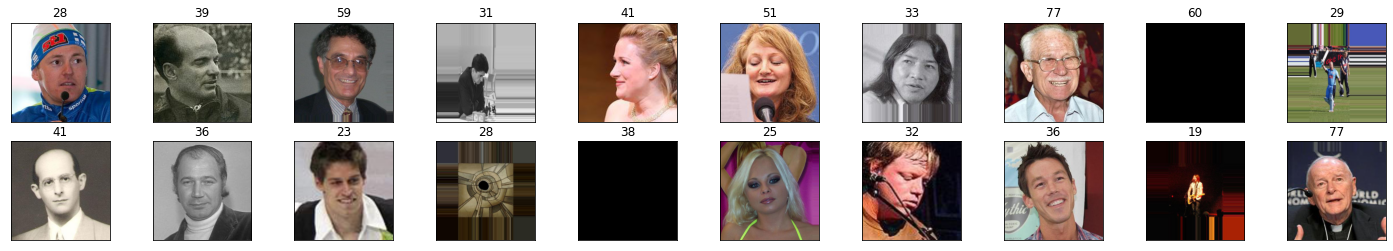

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
data = dataiter.next()
images, labels = data['image'], data['age']

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class Encoder(nn.Module):
  def __init__(self , image_in_channels , z_dim):
    super(Encoder , self).__init__()

    n_filters = 64

    self.conv1 = nn.Conv2d(image_in_channels , n_filters , kernel_size= 4 , stride=2 )
    self.batch_norm1 = nn.BatchNorm2d(n_filters)

    self.conv2 = nn.Conv2d(n_filters , n_filters * 2 , kernel_size=4 , stride=2)
    self.batch_norm2 = nn.BatchNorm2d(n_filters * 2)

    self.conv3 = nn.Conv2d(n_filters *2 , n_filters * 4 , kernel_size=4 , stride=2)
    self.batch_norm3 = nn.BatchNorm2d(n_filters * 4)

    self.conv4 = nn.Conv2d(n_filters * 4 , n_filters * 8 , kernel_size=4 , stride=2)
    self.batch_norm4 = nn.BatchNorm2d(n_filters * 8)

    self.conv5 = nn.Conv2d(n_filters * 8 , n_filters * 16 , kernel_size=4 , stride=2)
    self.batch_norm5 = nn.BatchNorm2d(n_filters * 16)

    self.relu = nn.ReLU(inplace=True)

    self.flatten = nn.Flatten()

    self.linear1 = nn.Linear(36864 , n_filters * 2)
    self.batch_norm_linear1 = nn.BatchNorm1d(n_filters * 2)
    self.linear2 = nn.Linear(n_filters * 2 , n_filters)
    self.batch_norm_linear2 = nn.BatchNorm1d(n_filters)
    self.linear3 = nn.Linear(n_filters , z_dim)


  def forward(self , x):
    x = self.conv1(x)
    x = self.batch_norm1(x)
    x = self.relu(x)

    x = self.conv2(x)
    x = self.batch_norm2(x)
    x = self.relu(x)

    x = self.conv3(x)
    x = self.batch_norm3(x)
    x = self.relu(x)

    x = self.conv4(x)
    x = self.batch_norm4(x)
    x = self.relu(x)

    x = self.conv5(x)
    x = self.batch_norm5(x)
    x = self.relu(x)

    x = self.flatten(x)

    x = self.linear1(x)
    x = self.batch_norm_linear1(x)
    x = self.relu(x)
    
    x = self.linear2(x)
    x = self.batch_norm_linear2(x)
    x = self.relu(x)

    x = self.linear3(x)

    return x



In [ ]:
encoder = Encoder(3 , 100)
encoder = encoder.to(device)

In [ ]:
summary(encoder , (3 , 256 , 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 127, 127]           3,136
       BatchNorm2d-2         [-1, 64, 127, 127]             128
              ReLU-3         [-1, 64, 127, 127]               0
            Conv2d-4          [-1, 128, 62, 62]         131,200
       BatchNorm2d-5          [-1, 128, 62, 62]             256
              ReLU-6          [-1, 128, 62, 62]               0
            Conv2d-7          [-1, 256, 30, 30]         524,544
       BatchNorm2d-8          [-1, 256, 30, 30]             512
              ReLU-9          [-1, 256, 30, 30]               0
           Conv2d-10          [-1, 512, 14, 14]       2,097,664
      BatchNorm2d-11          [-1, 512, 14, 14]           1,024
             ReLU-12          [-1, 512, 14, 14]               0
           Conv2d-13           [-1, 1024, 6, 6]       8,389,632
      BatchNorm2d-14           [-1, 102

In [ ]:
class Identity_preserving_optimization(nn.Module):
  def __init__(self , z_dim , z_star_dim):
    super(Identity_preserving_optimization , self).__init__()
    
    n_filters = 64

    self.linear1 = nn.Linear(z_dim , n_filters)
    self.batch_norm1 = nn.BatchNorm1d(n_filters)
    
    self.linear2 = nn.Linear(n_filters , n_filters * 2)
    self.batch_norm2  = nn.BatchNorm1d(n_filters * 2)

    self.linear3 = nn.Linear(n_filters * 2 , n_filters * 4)
    self.batch_norm3 = nn.BatchNorm1d(n_filters * 4)

    self.linear4 = nn.Linear(n_filters * 4 , n_filters * 8)
    self.batch_norm4 = nn.BatchNorm1d(n_filters * 8)

    self.linear5 = nn.Linear(n_filters * 8 , z_star_dim)
    
    self.relu = nn.ReLU()

  def forward(self , x):
    x = self.linear1(x)
    x = self.batch_norm1(x)
    x = self.relu(x)

    x = self.linear2(x)
    x = self.batch_norm2(x)
    x = self.relu(x)

    x = self.linear3(x)
    x = self.batch_norm3(x)
    x = self.relu(x)

    x = self.linear4(x)
    x = self.batch_norm4(x)
    x = self.relu(x)

    x = self.linear5(x)
    return x

    

In [ ]:
class conv(nn.Module):
  def __init__(self , in_channels , out_channels , kernel_size = 4 , strides = 2 , padding = 1 , batch_norm = True):
    super(conv , self).__init__()

    self.conv_layer = nn.Conv2d(in_channels , out_channels , kernel_size , strides , padding)
    self.batch_norm = batch_norm

    if self.batch_norm:
      self.batchnorm = nn.BatchNorm2d(out_channels)
    
  def forward(self , x):
    x = self.conv_layer(x)
    if self.batch_norm:
      x = self.batchnorm(x)
    
    return x

In [ ]:
class Discriminator(nn.Module):
  def __init__(self , y_size , conv_dim = 64):
    super(Discriminator , self).__init__()

    self.y_size = y_size
    self.conv_dim = conv_dim

    self.conv1 = nn.Conv2d(3 , 58 , kernel_size=2 , stride=2 )
    self.relu = nn.ReLU(inplace=True)

    self.seq = nn.Sequential(
        
        nn.Conv2d(58 + y_size , conv_dim * 2 , kernel_size=2 , stride=2) , 
        nn.BatchNorm2d(conv_dim * 2) , 
        nn.ReLU(inplace=True) , 

        nn.Conv2d(conv_dim * 2 , conv_dim * 4 , kernel_size=2 , stride=2) , 
        nn.BatchNorm2d(conv_dim  *4) , 
        nn.ReLU(inplace=True) , 

        nn.Conv2d(conv_dim * 4 , conv_dim * 16 , kernel_size=2 , stride=2 ) , 
        nn.BatchNorm2d(conv_dim * 16) , 
        nn.ReLU(inplace=True) , 

        nn.Conv2d(conv_dim * 16 , conv_dim * 32 , kernel_size=2 , stride=2) , 
        nn.BatchNorm2d(conv_dim * 32) , 
        nn.ReLU(inplace=True) , 

        nn.Conv2d(conv_dim * 32 , conv_dim * 64 , kernel_size=2 , stride=2 ) , 
        nn.BatchNorm2d(conv_dim * 64) , 
        nn.ReLU(inplace=True) , 

        nn.Conv2d(conv_dim * 64 , conv_dim , kernel_size=2 , stride=2) ,  
        nn.BatchNorm2d(conv_dim),
        nn.ReLU(inplace=True) , 

        nn.Conv2d(conv_dim, 1, kernel_size=2 , stride=2 , padding = 0) ,  
        #nn.ReLU(inplace=True) , 

)

  def forward(self , x , y):
    x = self.conv1(x)
    x = self.relu(x)
    y = y.view(-1,y.size()[-1],1,1)
    y = y.expand(-1,-1,x.size()[-2], x.size()[-1])
    x = torch.cat([x, y], 1)
    x = self.seq(x)
    
    return x


In [ ]:
disc = Discriminator(6)

In [ ]:

real_images_ = torch.randn(32 , 3 , 256 , 256)
ages_ = torch.randn(32 , 6)

_ = disc(real_images_ , ages_)
_.shape

torch.Size([32, 1, 1, 1])

In [ ]:
'''class Discriminator_(nn.Module):
  def __init__(self , y_size , conv_dim = 64):
    super(Discriminator_ , self).__init__()

    self.seq = nn.Sequential(
        nn.Conv2d(3 , 58 + y_size , kernel_size=2 , stride=2 , padding=128) , 
        nn.ReLU(inplace=True) , 

        nn.Conv2d(58 + y_size , conv_dim * 2 , kernel_size=2 , stride=2) , 
        nn.BatchNorm2d(conv_dim * 2) , 
        nn.ReLU(inplace=True) , 

        nn.Conv2d(conv_dim * 2 , conv_dim * 4 , kernel_size=2 , stride=2) , 
        nn.BatchNorm2d(conv_dim  *4) , 
        nn.ReLU(inplace=True) , 

        nn.Conv2d(conv_dim * 4 , conv_dim * 16 , kernel_size=2 , stride=2 ) , 
        nn.BatchNorm2d(conv_dim * 16) , 
        nn.ReLU(inplace=True) , 

        nn.Conv2d(conv_dim * 16 , conv_dim * 32 , kernel_size=2 , stride=2) , 
        nn.BatchNorm2d(conv_dim * 32) , 
        nn.ReLU(inplace=True) , 

        nn.Conv2d(conv_dim * 32 , conv_dim * 64 , kernel_size=2 , stride=2 ) , 
        nn.BatchNorm2d(conv_dim * 64) , 
        nn.ReLU(inplace=True) , 

        nn.Conv2d(conv_dim * 64 , conv_dim * 32 , kernel_size=2 , stride=2) ,  
        nn.BatchNorm2d(conv_dim * 32),
        nn.ReLU(inplace=True) , 

        nn.Conv2d(conv_dim * 32 , conv_dim * 16 , kernel_size=2 , stride=2) , 
        nn.BatchNorm2d(conv_dim * 16) , 
        nn.ReLU(inplace=True) , 

        nn.Conv2d(conv_dim * 16 , 1 , kernel_size=2 , stride=2) , 
        nn.ReLU(inplace=True)
    )
  def forward(self , x):
    return self.seq(x)'''

'class Discriminator_(nn.Module):\n  def __init__(self , y_size , conv_dim = 64):\n    super(Discriminator_ , self).__init__()\n\n    self.seq = nn.Sequential(\n        nn.Conv2d(3 , 58 + y_size , kernel_size=2 , stride=2 , padding=128) , \n        nn.ReLU(inplace=True) , \n\n        nn.Conv2d(58 + y_size , conv_dim * 2 , kernel_size=2 , stride=2) , \n        nn.BatchNorm2d(conv_dim * 2) , \n        nn.ReLU(inplace=True) , \n\n        nn.Conv2d(conv_dim * 2 , conv_dim * 4 , kernel_size=2 , stride=2) , \n        nn.BatchNorm2d(conv_dim  *4) , \n        nn.ReLU(inplace=True) , \n\n        nn.Conv2d(conv_dim * 4 , conv_dim * 16 , kernel_size=2 , stride=2 ) , \n        nn.BatchNorm2d(conv_dim * 16) , \n        nn.ReLU(inplace=True) , \n\n        nn.Conv2d(conv_dim * 16 , conv_dim * 32 , kernel_size=2 , stride=2) , \n        nn.BatchNorm2d(conv_dim * 32) , \n        nn.ReLU(inplace=True) , \n\n        nn.Conv2d(conv_dim * 32 , conv_dim * 64 , kernel_size=2 , stride=2 ) , \n        nn.BatchN

In [ ]:
#discriminator_ = Discriminator_(100)
#discriminator_ = discriminator_.to(device)

In [ ]:
#summary(discriminator_ , (3 , 256 , 256))

In [ ]:
  class deconv(nn.Module):
    def __init__(self , in_channels , out_channels , kernel_size = 4 , stride = 2 , padding = 1 , batch_norm = True):
      super(deconv , self).__init__()

      self.convT = nn.ConvTranspose2d(in_channels , out_channels , kernel_size , stride , padding)
      self.batch_norm = batch_norm

      if self.batch_norm:
        self.batchnorm = nn.BatchNorm2d(out_channels)
    
    def forward(self , x):
      x = self.convT(x)
      if self.batch_norm:
        x = self.batchnorm(x)
      return x

In [ ]:
class Generator(nn.Module):
  def __init__(self , z_dim , y_dim , conv_dim = 64):
    super(Generator , self).__init__()

    self.deconv1 = deconv(z_dim + y_dim , conv_dim * 8 , kernel_size = 4 , stride=2 , padding = 0)
    self.deconv2 = deconv(conv_dim * 8 , conv_dim * 16 , 4)
    self.deconv3 = deconv(conv_dim * 16 , conv_dim * 8)
    self.deconv4 = deconv(conv_dim * 8 , conv_dim * 8)
    self.deconv5 = deconv(conv_dim * 8 , conv_dim * 4 , 4 ,)
    self.deconv6 = deconv(conv_dim * 4 , conv_dim * 2 , 4 , 2 , 1)
    self.deconv7 = deconv(conv_dim * 2 , 3 , 4 , 2 , 1 , batch_norm=False)
    self.relu = nn.ReLU(inplace=True)

  def forward(self , z , y):
    x = torch.cat([z , y] , dim = 1)
    x = x.view(-1, x.size()[-1], 1, 1)
    x = self.relu(self.deconv1(x))
    x = self.relu(self.deconv2(x))
    x = self.relu(self.deconv3(x))
    x = self.relu(self.deconv4(x))
    x = self.relu(self.deconv5(x))
    x = self.relu(self.deconv6(x))
    x = self.deconv7(x)
    x = torch.tanh(x)
    #x = torch.reshape(x , (x.shape[0] , 3 , 256 , 256))
    return x
  

In [ ]:
generator = Generator(100 , 6)

In [ ]:
z = torch.randn(32 , 100)
y = torch.randn(32 , 6)
x = generator(z , y)
x.shape

torch.Size([32, 3, 256, 256])

In [ ]:

print(generator)

Generator(
  (deconv1): deconv(
    (convT): ConvTranspose2d(106, 512, kernel_size=(4, 4), stride=(2, 2))
    (batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): deconv(
    (convT): ConvTranspose2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batchnorm): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv3): deconv(
    (convT): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv4): deconv(
    (convT): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv5): deconv(
    (convT): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batchnorm): BatchNorm2d(256, eps=1

In [ ]:
conv_dim = 64
z_size = 100
z_star_size = 100
y_size = 6
image_in_channels = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoder = Encoder(image_in_channels , z_size)
identity_preserving_optimizer = Identity_preserving_optimization(z_size , z_star_size)
discriminator = Discriminator(y_size , conv_dim=conv_dim)
generator = Generator(z_size , y_size , conv_dim)

encoder = encoder.to(device)
identity_preserving_optimizer = identity_preserving_optimizer.to(device)
discriminator = discriminator.to(device)
generator = generator.to(device)

In [ ]:
print(encoder)

Encoder(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2))
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
  (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
  (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2))
  (batch_norm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2))
  (batch_norm5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=36864, out_features=128, bias=True)
  (batch_norm_linear1): BatchNorm1d(128, eps=1

In [ ]:
print(identity_preserving_optimizer)

Identity_preserving_optimization(
  (linear1): Linear(in_features=100, out_features=64, bias=True)
  (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=64, out_features=128, bias=True)
  (batch_norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=128, out_features=256, bias=True)
  (batch_norm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear4): Linear(in_features=256, out_features=512, bias=True)
  (batch_norm4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear5): Linear(in_features=512, out_features=100, bias=True)
  (relu): ReLU()
)


In [ ]:
print(generator)

Generator(
  (deconv1): deconv(
    (convT): ConvTranspose2d(106, 512, kernel_size=(4, 4), stride=(2, 2))
    (batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): deconv(
    (convT): ConvTranspose2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batchnorm): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv3): deconv(
    (convT): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv4): deconv(
    (convT): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv5): deconv(
    (convT): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batchnorm): BatchNorm2d(256, eps=1

In [ ]:
print(discriminator)

Discriminator(
  (conv1): Conv2d(3, 58, kernel_size=(2, 2), stride=(2, 2))
  (relu): ReLU(inplace=True)
  (seq): Sequential(
    (0): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 1024, kernel_size=(2, 2), stride=(2, 2))
    (7): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(1024, 2048, kernel_size=(2, 2), stride=(2, 2))
    (10): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(2048, 4096, kernel_size=(2, 2), stride=(2, 2))
    (13): BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [ ]:
def real_loss(d_out , smooth = False):
  batch_size = d_out.size(0)
  if smooth:
    labels = torch.ones(batch_size) * 0.9

  else:
    labels = torch.ones(batch_size)

  labels = labels.to(device)
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(d_out.squeeze() , labels)
  return loss

In [ ]:

def fake_loss(d_out):
  batch_size = d_out.size(0)
  labels = torch.zeros(batch_size)
  labels = labels.to(device)

  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(d_out.squeeze() , labels)
  return loss

In [ ]:
lr = 0.0002
beta1=0.5
beta2=0.999


num_epochs = 50

d_optimizer = torch.optim.Adam(discriminator.parameters() , lr = lr , betas=(beta1 , beta2))
g_optimizer = torch.optim.Adam(generator.parameters() , lr = lr , betas=(beta1 , beta2))
i_optimizer = torch.optim.Adam(identity_preserving_optimizer.parameters() , lr = lr , betas=(beta1 , beta2))

In [ ]:
def checkpoint(G, D, epoch, model, root_dir):
    target_dir = f'{root_dir}/{model}'
    os.makedirs(target_dir, exist_ok=True)
    G_path = os.path.join(target_dir, f'G_{epoch}.pkl')
    D_path = os.path.join(target_dir, f'D_{epoch}.pkl')
    torch.save(G.state_dict(), G_path)
    torch.save(D.state_dict(), D_path)

def oh_to_class(fixed_y):
    age_map = {0:'0-18',1:'19-29',2:'30-39',3:'40-49',4:'50-59',5:'60+'}
    if torch.cuda.is_available():
        fixed_y = fixed_y.cpu()
    fixed_y_idxs = fixed_y.numpy().nonzero()[1]
    fixed_y_ages = [age_map[idx] for idx in fixed_y_idxs]
    
    return fixed_y_ages

def save_samples_ages(samples, fixed_y, model, root_dir):
    fixed_y_ages = oh_to_class(fixed_y)
    samples_ages = {'samples': samples, 'ages': fixed_y_ages}
    target_dir = f'{root_dir}/{model}'
    os.makedirs(target_dir, exist_ok=True)
    with open(f'{target_dir}/train_samples_ages.pkl', 'wb') as f:
        pkl.dump(samples_ages, f)

In [ ]:
%%time

root_dir = '/content/Age-cGAN'
model = 'GAN_1'
os.makedirs(root_dir, exist_ok=True)


generator.to(device)
discriminator.to(device)

import pickle as pkl




samples = []
losses = []

print_every = 300


sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
fixed_y = np.random.randint(len(bins), size=sample_size)
fixed_y = fixed_y.reshape(-1,1)
fixed_y = torch.zeros(sample_size, len(bins)+1).scatter_(1, torch.tensor(fixed_y), 1)

CPU times: user 3.8 ms, sys: 0 ns, total: 3.8 ms
Wall time: 4.09 ms


In [ ]:
for epoch in range(num_epochs):
  
  for batch_i, batch in enumerate(tqdm(train_loader)):

    batch_size = batch['image'].size(0)

    real_images = scale(batch['image'])

    ages = one_hot(batch['age'], bins)
    #print(ages.shape)

    real_images = real_images.to(device)
    ages = ages.to(device)

    z = encoder(real_images)
    z = z.to(device)

    d_optimizer.zero_grad()


    #print(real_images.shape , ages.shape)

    D_real = discriminator(real_images , ages)
    d_real_loss = real_loss(D_real)


    fake_images = generator(z, ages)
    D_fake = discriminator(fake_images , ages)
    d_fake_loss = fake_loss(D_fake)
    d_loss = d_real_loss + d_fake_loss
    d_loss.backward()
    d_optimizer.step()

    g_optimizer.zero_grad()





    #print(real_images.shape)

    
    #z = torch.from_numpy(z).float()

    

    
    #print(fake_images.shape)

    fake_images_initial_reconstruction = generator(z , ages)


    z_star = identity_preserving_optimizer(z)
    #z = np.random.uniform(-1, 1, size=(batch_size, z_size))
    #z = torch.from_numpy(z).float()
    z_star = z_star.to(device)
    fake_images_optimized = generator(z_star, ages)

    D_fake = discriminator(fake_images_optimized, ages)
    g_loss = real_loss(D_fake)
    

    g_loss.backward()
    g_optimizer.step()


    if batch_i % print_every == 0:

        losses.append((d_loss.item(), g_loss.item()))
  
        print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                epoch+1, num_epochs, d_loss.item(), g_loss.item()))
        

  generator.eval() 
  fixed_z = fixed_z.to(device)
  fixed_y = fixed_y.to(device)
  samples_z = generator(fixed_z, fixed_y)
  samples.append(samples_z)
  generator.train() 
  

  checkpoint(generator, discriminator , epoch, model, root_dir)


save_samples_ages(samples, fixed_y, model, root_dir)




RuntimeError: ignored